**Brian Blaylock**  
**May 17, 2019**  

# **Fig. 8** May 2019 Case: count of runs forecasting lightning

![](./figs/Fig-08_May2019-Case.png)

Also include GOES-17 GLM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import multiprocessing
import os

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, get_hrrr_latlon
from BB_GOES.get_GOES import get_GOES_nearesttime
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST, filter_by_HRRR
from BB_datetimes.range import range_dates
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats

from BB_GOES.get_GOES import get_GOES_nearesttime
from BB_HRRR.HRRR_Pando import get_hrrr_latlon
from BB_GOES.get_GLM import bin_GLM_on_HRRR_grid
import scipy.ndimage as ndimage

Create HRRR map.
loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_c_2000.npy map from file
Forecasts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Generate domains and masks.
HRRR Area in meters squared: 16811840278558.668
West Area in meters squared: 4034896806752.7593
Central Area in meters squared: 4034896806752.766
East Area in meters squared: 4034896806752.762
Utah Area in meters squared: 219973261639.39685
Colorado Area in meters squared: 269906899003.7569
Texas Area in meters squared: 688270731111.2987
Florida Area in meters squared: 149996892486.02234
dict_keys(['HRRR', 'West', 'Central', 'East', 'Utah', 'Colorado', 'Texas', 'Florida'])


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [7.5, 5.5]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.02
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600

In [3]:
def get_GLM_binary(validDATE, satellite=17, verbose=True):
    """Because we don't have GOES17 binaries saved to disk"""
    
    # Get contingency stats, which contains the binary field:
    if satellite==17:
        BASE = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary/HRRR-GLM-GOES17/'
        BINARY_FILE = BASE+'/HRRR-GLM-Binary_%s.npy' % validDATE.strftime('%Y-%m-%d_%H%M')

        if os.path.exists(BINARY_FILE):
            if verbose: print('>>Load binary stats from file', BINARY_FILE)
            stats = np.load(BINARY_FILE, allow_pickle=True).item()
            return stats
    
    # 1) Get GLM Events for the previous hour.
    if verbose: print('(1/7) Get GLM Events. %s' % validDATE)
    files = get_GOES_nearesttime(validDATE-timedelta(minutes=30),
                                 product='GLM', satellite=satellite, window=30, verbose=False)
    E = accumulate_GLM_FAST(files, data_type='event', verbose=False)

    if verbose: print('\nGot %s of %s expected files.' % (files['Number'], files['Number Expected']))
    if E == None:
        print('return None')
    if verbose: print('Total Events: {:,}'.format(len(E['longitude'])))
        
    ## 2) Get HRRR Lightning data and lat/lon grid.
    if verbose: print('(2/7) Get HRRR Data.')
    Hlat, Hlon = get_hrrr_latlon(DICT=False)   
    
    if verbose: print('(3/7) Filter GLM.')
    if verbose: print('(4/7) Put GLM on HRRR grid.')
    hist, filtered = bin_GLM_on_HRRR_grid(E, Hlat, Hlon, m)
    if verbose: print('In-HRRR Events: {:,}'.format(np.sum(filtered)))
    custom_filter = np.array([[0,1,1,1,0],
                          [1,1,1,1,1],
                          [1,1,1,1,1],
                          [1,1,1,1,1],
                          [0,1,1,1,0]])
    bloat_glm = ndimage.generic_filter(hist, np.max, footprint=custom_filter)
    Observed_binary = bloat_glm > 1     # More than 1 GLM event in a grid box.
    
    return_this = {'Observed Binary':Observed_binary,
                   'DATETIME':validDATE}
    # Save the dictionary for later use
    if satellite==17:
        np.save(BINARY_FILE, return_this)
        if verbose: print('\n***Saved Binary Dictionary:', BINARY_FILE, '***\n')
    
    return return_this

In [4]:
mU = draw_centermap('Utah', size=(4,4))

In [5]:
m = draw_HRRR_map()
lat, lon = get_hrrr_latlon(DICT=False)

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_i_2000.npy map from file


In [6]:
DATES = [datetime(2019, 5, 7, 19),
         #datetime(2019, 5, 7, 21),
         datetime(2019, 5, 7, 23),
         #datetime(2019, 5, 8, 1),
         datetime(2019, 5, 8, 3)]

>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary/HRRR-GLM-GOES17//HRRR-GLM-Binary_2019-05-07_1900.npy


/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: No contour levels were found within the data range.
  
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary/HRRR-GLM-GOES17//HRRR-GLM-Binary_2019-05-07_2300.npy
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary/HRRR-GLM-GOES17//HRRR-GLM-Binary_2019-05-08_0300.npy


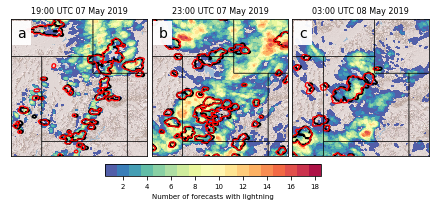

In [12]:
fig, axes  = plt.subplots(1, len(DATES))

for ax, DATE, label in zip(axes, DATES, ['a', 'b', 'c']):
    plt.sca(ax)
    stats = get_GLM_HRRR_contingency_stats(DATE, verbose=False)
    stats17 = get_GLM_binary(DATE, satellite=17, verbose=True)
    
    fxx_num = np.sum(stats['Forecast Binary'], axis=0)
    fxx_masked = np.ma.array(fxx_num, mask=fxx_num==0)
    #mU.pcolormesh(lon, lat, fxx_masked, latlon=True)
    im = mU.contourf(lon, lat, fxx_masked, latlon=True, levels=range(1,20,1), cmap='Spectral_r')
    
    mU.contour(lon, lat, stats['Observed Binary'], latlon=True, levels=[0,1],
               colors='k', linestyles='-', linewidths=1.75)
    
    mU.contour(lon, lat, stats17['Observed Binary'], latlon=True, levels=[0,1],
               colors='r', linestyles='-', linewidths=1.25)
    
    plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'))
    
    mU.arcgisimage(service='World_Shaded_Relief', xpixels=1000)   
    mU.drawstates()
    
    
    bbox = {'facecolor':'white',
            'alpha':0.95,
            'pad':5,
            'edgecolor':'none'}
    ax.text(0.05,.95, label, bbox=bbox, va='top', ha='left',
            fontsize=14, transform=ax.transAxes, zorder=1000);
    
cbar_ax = fig.add_axes([0.3, .28, 0.4, 0.03])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
             label='Number of forecasts with lightning')

labels = range(2,20,2)
cbar.set_ticks(np.arange(2.5, np.max(labels) + 1, 2))
cbar.ax.set_xticklabels(labels);

plt.savefig('./figs/Fig-08_May2019-Case')